In [1]:
from mlp import data_loader, metrics,wrapper,transformer,model,preprocessor,rounder

In [2]:

# read data
train, test, train_labels, specs, sample_submission = data_loader.read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, list_title_event_code = data_loader.encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = data_loader.get_train_and_test(train,test, assess_titles,list_of_event_code,list_of_event_id,activities_labels,list_title_event_code,win_code)

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns
100%|██████████| 1000/1000 [00:28<00:00, 34.70it/s]


In [3]:

# call feature engineering function
reduce_train, reduce_test, features = preprocessor.preprocess(reduce_train, reduce_test,assess_titles)

In [4]:
params = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
         'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 100,
            'early_stopping_rounds': 100, 'eval_metric': 'cappa'
            }

In [5]:
y = reduce_train['accuracy_group']

In [6]:
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
n_fold = 5
folds = GroupKFold(n_splits=n_fold)

In [7]:
cols_to_drop = ['game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate']

Fold 1 started at Wed Dec 11 15:36:29 2019
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.905795	train's cappa: 0.680564	valid's rmse: 0.977572	valid's cappa: 0.616048
[200]	train's rmse: 0.839157	train's cappa: 0.740455	valid's rmse: 0.970374	valid's cappa: 0.616178
Early stopping, best iteration is:
[170]	train's rmse: 0.856243	train's cappa: 0.723381	valid's rmse: 0.970881	valid's cappa: 0.621719
Fold 2 started at Wed Dec 11 15:36:54 2019
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.90752	train's cappa: 0.678811	valid's rmse: 0.988091	valid's cappa: 0.609759
[200]	train's rmse: 0.840551	train's cappa: 0.736994	valid's rmse: 0.982349	valid's cappa: 0.6157
[300]	train's rmse: 0.792839	train's cappa: 0.7761	valid's rmse: 0.982391	valid's cappa: 0.614463
Early stopping, best iteration is:
[216]	train's rmse: 0.832161	train's cappa: 0.743291	valid's rmse: 0.982137	valid's cappa: 0.619715
Fold 3 started at Wed Dec

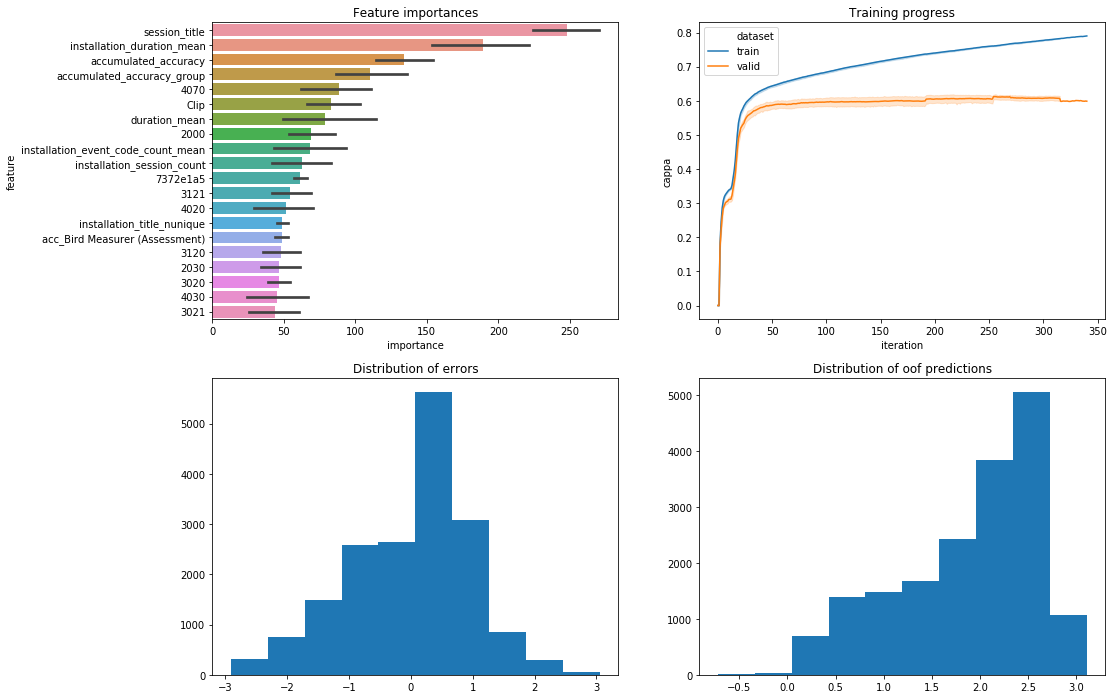

In [8]:
mt = transformer.MainTransformer()
ft = transformer.FeatureTransformer()
transformers = {'ft': ft}
regressor_model1 = model.RegressorModel(model_wrapper=wrapper.LGBWrapper_regr())
regressor_model1.fit(X=reduce_train, y=y, folds=folds, params=params, preprocesser=mt, transformers=transformers,
                    eval_metric='cappa', cols_to_drop=cols_to_drop)

In [9]:
%%time
pr1 = regressor_model1.predict(reduce_train)

optR = rounder.OptimizedRounder()
optR.fit(pr1.reshape(-1,), y)
coefficients = optR.coefficients()

Wall time: 8.42 s


In [15]:

opt_preds = optR.predict(pr1.reshape(-1, ), coefficients)
metrics.qwk(y, opt_preds)

IndexError: index 1000 is out of bounds for axis 0 with size 1000

In [17]:
# some coefficients calculated by me.
import numpy as np
pr1 = regressor_model1.predict(reduce_test)
pr1[pr1 <= 1.12232214] = 0
pr1[np.where(np.logical_and(pr1 > 1.12232214, pr1 <= 1.73925866))] = 1
pr1[np.where(np.logical_and(pr1 > 1.73925866, pr1 <= 2.22506454))] = 2
pr1[pr1 > 2.22506454] = 3

In [18]:
sample_submission['accuracy_group'] = pr1.astype(int)
sample_submission.to_csv('submission.csv', index=False)

In [19]:
sample_submission['accuracy_group'].value_counts(normalize=True)

3    0.346
2    0.307
1    0.176
0    0.171
Name: accuracy_group, dtype: float64